In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('HR_capstone_dataset.csv')
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# Pre-Processing

In [3]:
df = data.copy()

In [4]:
df = df.drop('last_evaluation',axis = 1)
#permet d'avoir une précison meilleure de 1 % sur la détection des personnes ayant 0 dans la colonne 'left'

# TrainTest - Nettoyage - Encodage

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
trainset['left'].value_counts(normalize=True)

0    0.76123
1    0.23877
Name: left, dtype: float64

In [8]:
testset['left'].value_counts(normalize=True)

0    0.764667
1    0.235333
Name: left, dtype: float64

In [9]:
def encodage(df):
    df = pd.get_dummies(df, columns=['Department', 'salary', 'number_project', 'time_spend_company'], drop_first=True)
    return df

In [11]:
(df.isna().sum()/df.shape[0]).sort_values()

satisfaction_level       0.0
number_project           0.0
average_montly_hours     0.0
time_spend_company       0.0
Work_accident            0.0
left                     0.0
promotion_last_5years    0.0
Department               0.0
salary                   0.0
dtype: float64

#### Pas besoin de traiter les valeurs NaN

In [12]:
def preprocessing(df):
    df = encodage(df)

    X = df.drop('left', axis = 1)
    y = df['left']

    print(y.value_counts(normalize=True))
    return X, y

In [13]:
X_train, y_train = preprocessing(trainset)

0    0.76123
1    0.23877
Name: left, dtype: float64


In [14]:
X_test, y_test = preprocessing(testset)

0    0.764667
1    0.235333
Name: left, dtype: float64


In [36]:
#from imblearn.over_sampling import SMOTE
#X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
#y_train_resampled.value_counts(normalize=True)
#dégrade la performance

# Evaluation

In [15]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [16]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    model.fit(X_train_resampled, y_train_resampled)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))  

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

# Modelisation

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [18]:
RandomForest = RandomForestClassifier(random_state=0)
AdaBoost = AdaBoostClassifier(random_state=42)
SVM = make_pipeline(StandardScaler(), SVC(random_state=42))
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())

In [19]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest
[[2281   13]
 [  29  677]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2294
           1       0.98      0.96      0.97       706

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000

AdaBoost
[[2240   54]
 [  92  614]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2294
           1       0.92      0.87      0.89       706

    accuracy                           0.95      3000
   macro avg       0.94      0.92      0.93      3000
weighted avg       0.95      0.95      0.95      3000

SVM
[[2246   48]
 [  81  625]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2294
           1       0.93      0.89      0.91       706

    accuracy                           0.96      3000
   macro avg       0.

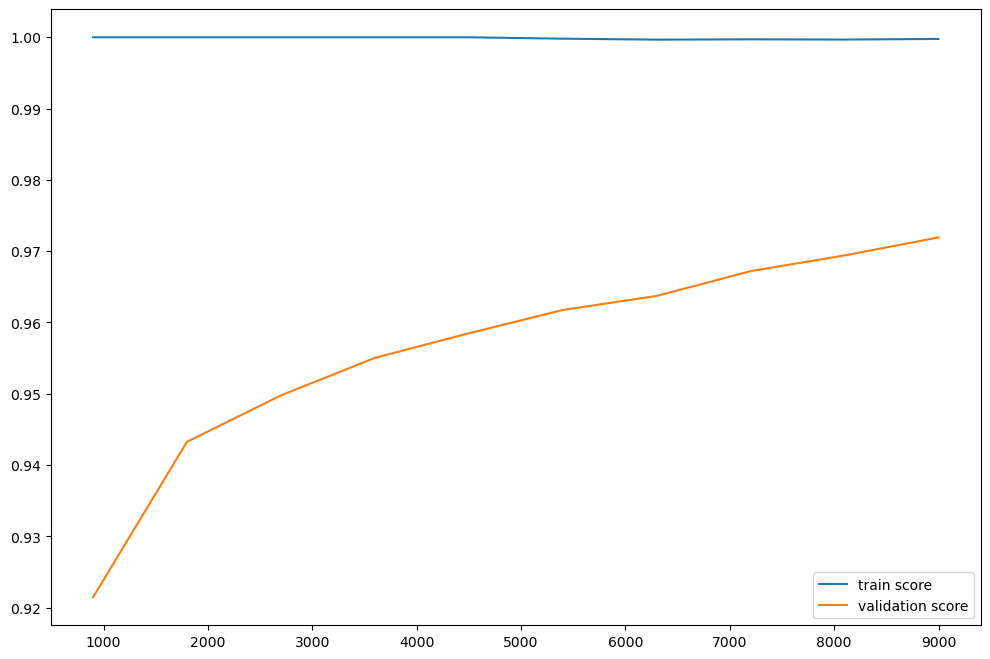

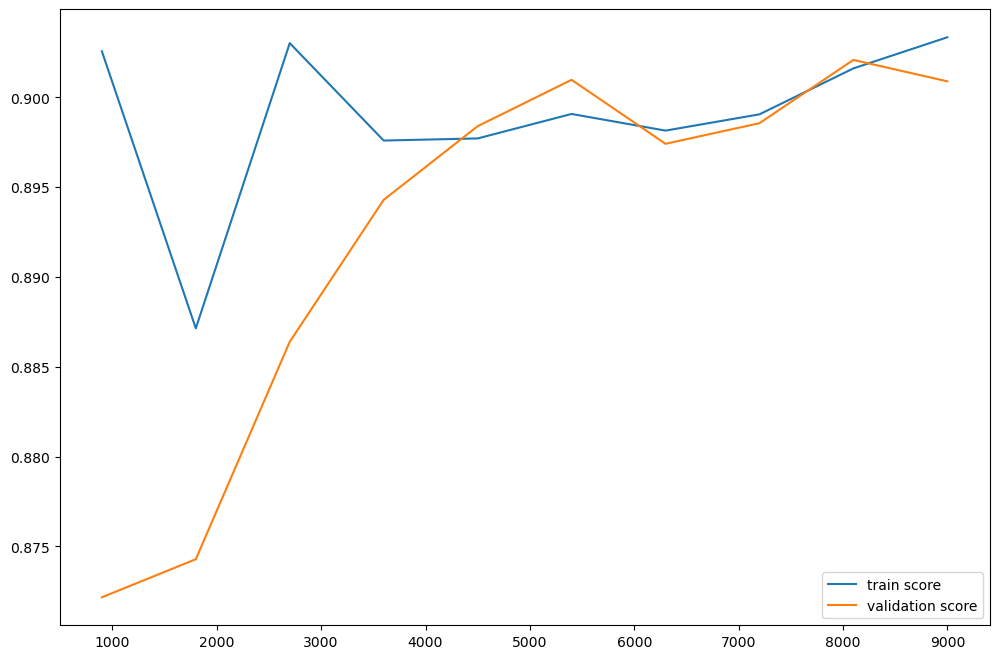

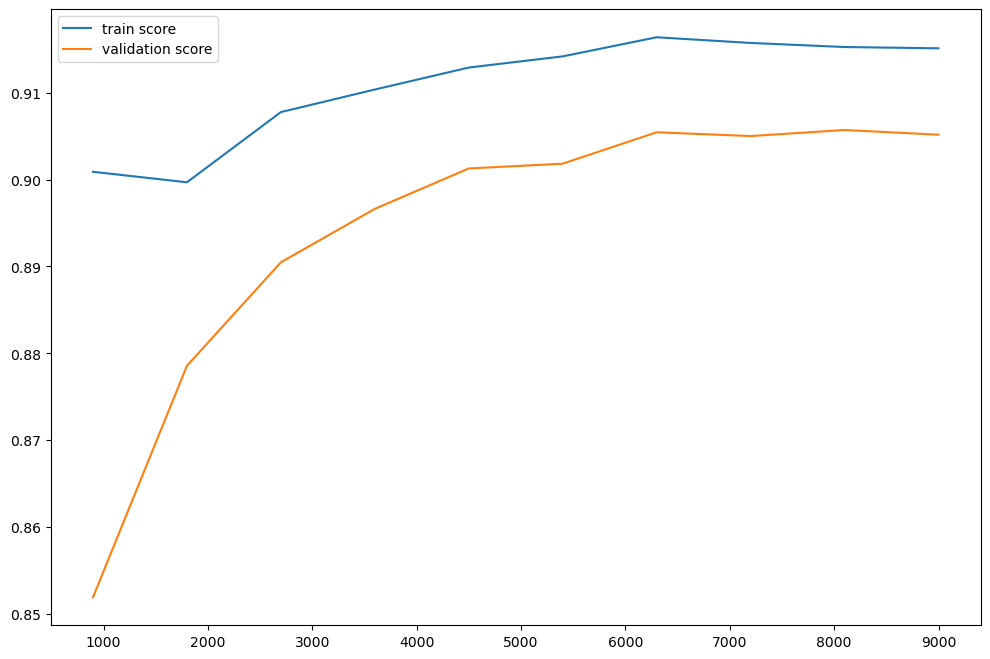

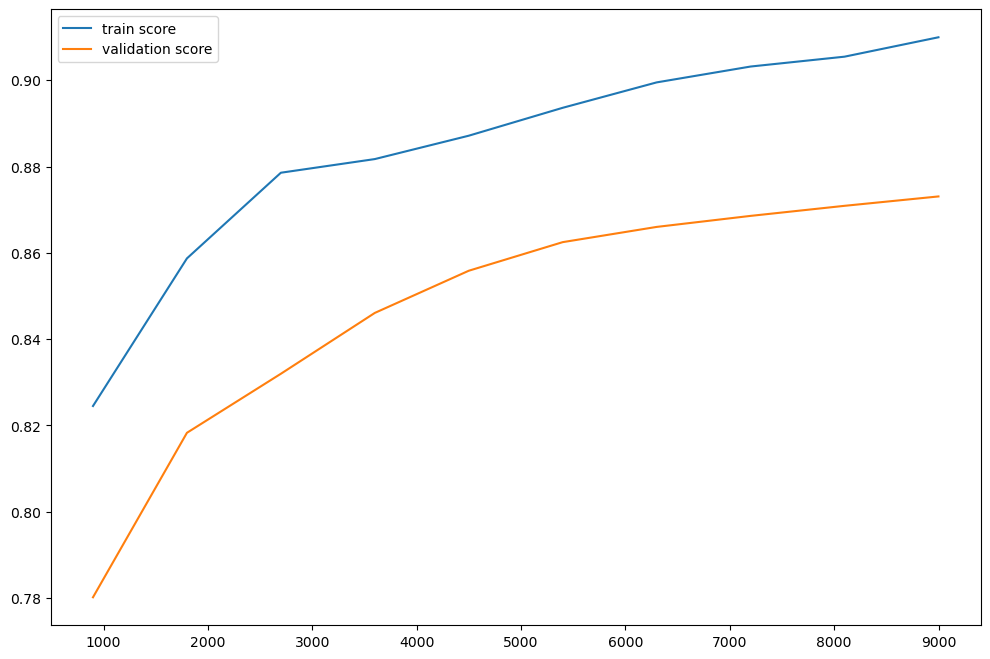

In [20]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

### Je vais me concentrer sur RandomForest qui a la meilleure combinaison F1 score et recall pour détecter les employés partis de l'entreprise. 

# OPTIMISATION

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [21]:
RandomForest

RandomForestClassifier(random_state=0)

In [33]:
hyper_params = {'n_estimators':[65,70,75,80,85],
                'criterion':['gini', 'entropy', 'log_loss'],
                'max_depth': [5,10,15,20,None]}

In [35]:
grid = GridSearchCV(RandomForest, hyper_params, scoring='f1', cv=4)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'criterion': 'gini', 'max_depth': None, 'n_estimators': 65}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2294
           1       0.98      0.96      0.97       706

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



# Precision Recall Curve

In [37]:
from sklearn.metrics import precision_recall_curve

In [40]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

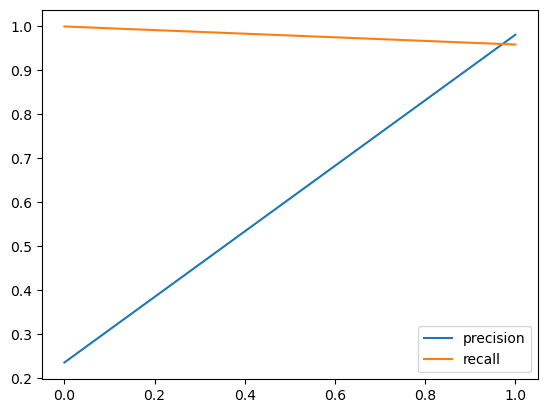

In [41]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [42]:
def model_final(model, X, threshold):
    return model.decision_function(X) > threshold

In [43]:
y_pred = model_final(RandomForest, X_test, threshold=1)

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'